In [ ]:
# Import the required Libraries
import joblib
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from transformers import BertTokenizer, BertForSequenceClassification

# Load the DataSet

https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning

In [2]:
# Read the dataset
DATA_PATH = r"/home/andy/Projects/phisher"

SEED = 120  # For reproducibility

data = pd.read_csv(os.path.join(DATA_PATH, "Phishing_Legitimate_full.csv"))

data.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


# Exploratory Data Analysis

In [3]:
# Check the info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [4]:
# Check the columns
data.columns

Index(['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperl

In [5]:
# Describe the data
data.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,...,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,...,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10000.00000,21.000000,14.000000,18.000000,253.000000,55.000000,9.000000,1.000000,1.000000,18.00000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Summary of Exploratory Data Analysis

- Our dataset contains no missing values.

- Our dataset has 10000 records and 48 features and id column and a label giving us 10000 rows and 50 columns 

# Feature Extraction

In [5]:
# Drop irrelevant columns
data.drop(columns="id", axis=1, inplace=True)

# Check the colums
data.head()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


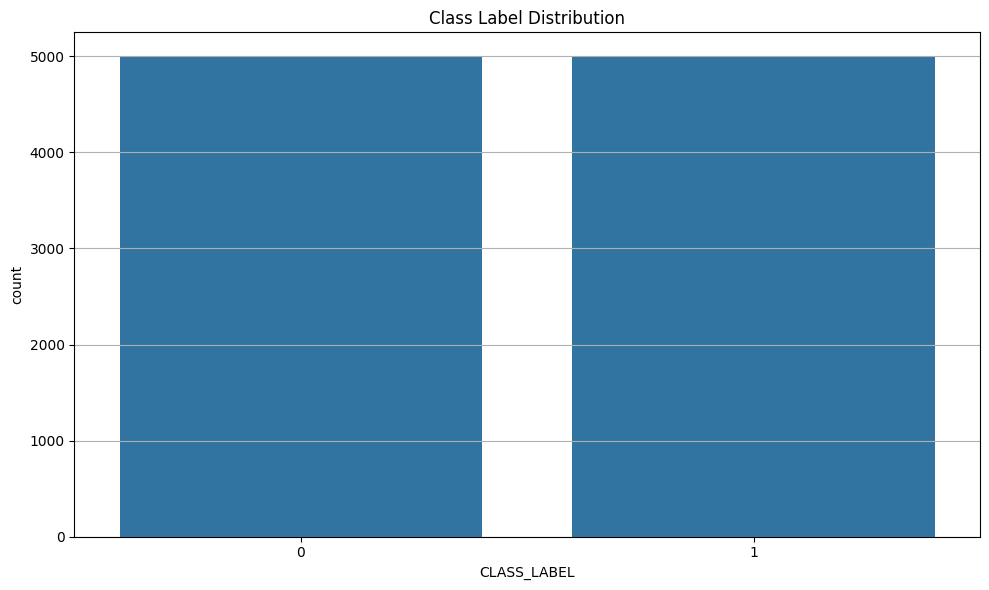

In [7]:
# Check label distribution
plt.figure(figsize=(10, 6))

sns.countplot(x="CLASS_LABEL", data=data)
plt.title("Class Label Distribution")
plt.tight_layout()
plt.grid(visible=True, axis="y")
plt.show()

### Summary of Feature Extraction
- The id column was irrelevant to the research we are trying to perform. Hence it was dropped.

- Our dataset labels are balanced with the value counts for each of them being 5000 each

# Splitting the Data

In [7]:
# Define X and y
X = data.drop(columns="CLASS_LABEL")  # independent variables
y = data["CLASS_LABEL"]  # target variable

# Split the data into train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

- We split the dataset into train and test sets.

- The train set contains all but the CLASS_LABEL column. The train set is 80% of our dataset (8000 rows)

- The test set contains the CLASS_LABEL column. The test set is 20% of our dataset (2000 rows)

In [ ]:
# `X_train` is your feature DataFrame used for training
feature_names = X_train.columns.tolist()

# Save the feature names to a file
joblib.dump(feature_names, "feature_names.joblib")
print("Feature names saved!")

Feature names saved!


/home/andy/pythonenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:50:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


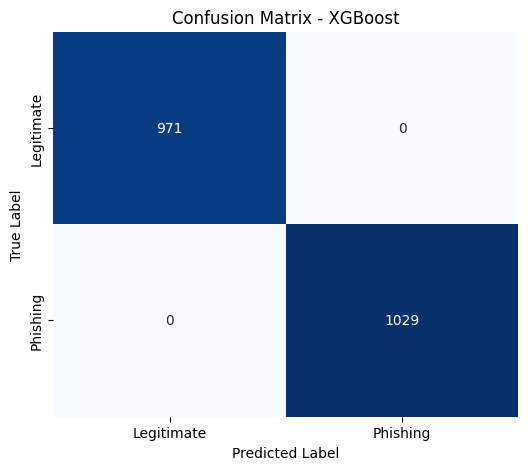

In [8]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"XGBoost Model Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plotting metrics bar chart
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
}
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Legitimate", "Phishing"],
    yticklabels=["Legitimate", "Phishing"],
)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [8]:
# Save model
xgb_model.save_model("xgboost_model.json")

In [12]:
# end of notebook